In [17]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [18]:
# Cargar datos de pacientes hospitalizados por día (ya procesados)
daily_counts = pd.read_csv("./data/daily_hospitalized_patients.csv")
# Parsear fechas
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Cargar datos climáticos
# df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [19]:
# Preparar datos para StatsForecast
forecast_df = daily_counts.rename(columns={"date": "ds", "num_patients": "y"}).copy()
forecast_df["unique_id"] = "hospital"
forecast_df = forecast_df[["unique_id", "ds", "y"]]
forecast_df.head()


,unique_id,ds,y
0,hospital,2017-04-01,30
1,hospital,2017-04-02,45
2,hospital,2017-04-03,65
3,hospital,2017-04-04,78
4,hospital,2017-04-05,71


In [43]:
# Configuración para pronóstico con ventana fija
train_window = 7  # Ventana de entrenamiento fija: 7 días
forecast_ahead_start = 7  # Primer pronóstico: 7 días adelante del último día de entrenamiento
num_forecasts = 7  # Generar 7 pronósticos con horizontes crecientes

# Verificar que tenemos suficientes datos
# Necesitamos: train_window (ventana fija) + forecast_ahead_start + num_forecasts - 1 (para el último pronóstico)
min_required = train_window + forecast_ahead_start + num_forecasts - 1
if len(forecast_df) < min_required:
    raise ValueError(f"Se necesitan al menos {min_required} días de datos, pero solo hay {len(forecast_df)}")

print(f"Configuración:")
print(f"  - Ventana de entrenamiento FIJA: {train_window} días")
print(f"  - Primer pronóstico: {forecast_ahead_start} días adelante")
print(f"  - Número de pronósticos: {num_forecasts}")
print(f"  - Horizontes de pronóstico: {forecast_ahead_start} a {forecast_ahead_start + num_forecasts - 1} días adelante")
print(f"  - Total de días necesarios: {min_required}")
print(f"  - Días disponibles: {len(forecast_df)}")


Configuración:
  - Ventana de entrenamiento FIJA: 7 días
  - Primer pronóstico: 7 días adelante
  - Número de pronósticos: 7
  - Horizontes de pronóstico: 7 a 13 días adelante
  - Total de días necesarios: 20
  - Días disponibles: 728


In [44]:
# Realizar pronóstico con ventana fija: usar siempre la misma ventana inicial
# y pronosticar 7 días diferentes con horizontes crecientes

results = []

# Calcular índices: usar siempre la misma ventana inicial desde el final del dataset
# Necesitamos espacio para: train_window + forecast_ahead_start + num_forecasts - 1
train_start = len(forecast_df) - min_required
train_end = train_start + train_window

# Obtener datos de entrenamiento (ventana fija de 7 días)
train_df = forecast_df.iloc[train_start:train_end].reset_index(drop=True)
last_train_value = train_df.iloc[-1]["y"]
last_train_date = train_df.iloc[-1]["ds"]

print(f"Ventana de entrenamiento FIJA:")
print(f"  - Fechas: {train_df.iloc[0]['ds'].strftime('%Y-%m-%d')} a {last_train_date.strftime('%Y-%m-%d')}")
print(f"  - Valores: {train_df['y'].tolist()}")
print(f"  - Último valor: {last_train_value:.2f}")
print(f"\nEntrenando modelo una vez con esta ventana...\n")

# Entrenar modelo UNA SOLA VEZ con la ventana fija
# AutoARIMA con parámetros ajustados para evitar tendencia constante y capturar variabilidad
sf = StatsForecast(
    models=[AutoARIMA(
        season_length=7,  # Patrón semanal
        max_order=10,      # Aumentar límite para permitir más complejidad
        max_p=5,           # Permitir más términos autorregresivos
        max_d=1,           # Reducir diferenciación para evitar tendencia constante
        max_q=5,           # Permitir más términos de media móvil
        max_P=2,           # Términos estacionales autorregresivos
        max_D=0,           # Sin diferenciación estacional para evitar tendencia
        max_Q=2,           # Términos estacionales de media móvil
        start_p=1,         # Forzar al menos 1 término AR para capturar variabilidad
        start_q=1,         # Forzar al menos 1 término MA para capturar variabilidad
        start_P=1,         # Forzar al menos 1 término AR estacional
        start_Q=1,         # Forzar al menos 1 término MA estacional
        stepwise=True,     # Búsqueda paso a paso más eficiente
        approximation=False,  # Usar estimación exacta (mejor pero más lento)
        trace=False,       # No mostrar búsqueda detallada
        seasonal=True,     # Forzar componente estacional
    )], 
    freq="D", 
    n_jobs=-1
)
sf = sf.fit(train_df)
print("✓ Modelo entrenado exitosamente\n")

# Mostrar información del modelo seleccionado para diagnóstico
try:
    model_info = sf.models[0].model_
    print("Información del modelo seleccionado:")
    print(f"  - Modelo: {model_info}")
    if hasattr(model_info, 'arparams'):
        print(f"  - Parámetros AR: {model_info.arparams}")
    if hasattr(model_info, 'maparams'):
        print(f"  - Parámetros MA: {model_info.maparams}")
    if hasattr(model_info, 'aic'):
        print(f"  - AIC: {model_info.aic:.2f}")
except Exception as e:
    print(f"  - No se pudo obtener información detallada del modelo: {e}")
print()

# Generar pronósticos para diferentes horizontes: 7, 8, 9, ..., 13 días adelante
# Hacer un pronóstico completo de todos los horizontes de una vez para mantener consistencia
max_horizon = forecast_ahead_start + num_forecasts - 1
forecast_full = sf.forecast(df=train_df, h=max_horizon)

print(f"Generando pronósticos para horizontes {forecast_ahead_start} a {max_horizon} días...\n")

for i in range(num_forecasts):
    forecast_ahead = forecast_ahead_start + i  # Horizonte creciente: 7, 8, 9, ..., 13
    
    # Calcular el índice del día que vamos a pronosticar
    forecast_idx = train_end + forecast_ahead - 1
    actual_value = forecast_df.iloc[forecast_idx]
    
    # Obtener el pronóstico para el horizonte específico (índice forecast_ahead - 1 porque empieza en 1)
    predicted_value = forecast_full.iloc[forecast_ahead - 1]["AutoARIMA"]
    
    # Calcular diferencia con el pronóstico anterior (si existe)
    if i > 0:
        prev_predicted = results[-1]["pronostico"]
        diff_con_anterior = predicted_value - prev_predicted
    else:
        diff_con_anterior = None
    
    # Guardar resultados
    results.append({
        "pronostico_num": i + 1,
        "horizonte_dias": forecast_ahead,
        "train_start_date": train_df.iloc[0]["ds"],
        "train_end_date": last_train_date,
        "forecast_date": actual_value["ds"],
        "ultimo_valor_entrenamiento": last_train_value,
        "real": actual_value["y"],
        "pronostico": predicted_value,
        "diferencia_con_ultimo": abs(predicted_value - last_train_value),
        "diferencia_con_anterior": diff_con_anterior if diff_con_anterior is not None else None,
        "cambio_real": actual_value["y"] - (results[-1]["real"] if i > 0 else last_train_value),
        "error": abs(actual_value["y"] - predicted_value),
        "error_relativo": abs(actual_value["y"] - predicted_value) / actual_value["y"] * 100
    })
    
    diff_info = f" (Δ={diff_con_anterior:+.2f})" if diff_con_anterior is not None else ""
    print(f"Pronóstico {i+1}: Horizonte {forecast_ahead} días → "
          f"Día {forecast_idx} ({actual_value['ds'].strftime('%Y-%m-%d')}) → "
          f"Pronóstico: {predicted_value:.2f}{diff_info}, Real: {actual_value['y']:.2f}")

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("ANÁLISIS DE VARIABILIDAD: Comparación entre pronósticos consecutivos y cambios reales")
print("=" * 80)
comparison_cols = ["pronostico_num", "horizonte_dias", "pronostico", "diferencia_con_anterior", "real", "cambio_real"]
display_df = results_df[comparison_cols].copy()
display_df["diferencia_con_anterior"] = display_df["diferencia_con_anterior"].apply(lambda x: f"{x:+.2f}" if x is not None else "N/A")
display_df["cambio_real"] = display_df["cambio_real"].apply(lambda x: f"{x:+.2f}")
print(display_df.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN DE VARIABILIDAD:")
print("=" * 80)
if len(results_df) > 1:
    cambios_predichos = results_df["diferencia_con_anterior"].dropna()
    cambios_reales = results_df["cambio_real"].iloc[1:]  # Excluir el primero
    
    print(f"Cambios promedio en pronósticos: {cambios_predichos.mean():.2f}")
    print(f"Desviación estándar cambios pronósticos: {cambios_predichos.std():.2f}")
    print(f"Rango de cambios pronósticos: [{cambios_predichos.min():.2f}, {cambios_predichos.max():.2f}]")
    print()
    print(f"Cambios promedio en valores reales: {cambios_reales.mean():.2f}")
    print(f"Desviación estándar cambios reales: {cambios_reales.std():.2f}")
    print(f"Rango de cambios reales: [{cambios_reales.min():.2f}, {cambios_reales.max():.2f}]")

print("\n" + "=" * 80)
results_df


Ventana de entrenamiento FIJA:
  - Fechas: 2019-03-10 a 2019-03-16
  - Valores: [185, 182, 196, 192, 147, 153, 145]
  - Último valor: 145.00

Entrenando modelo una vez con esta ventana...

✓ Modelo entrenado exitosamente

  - No se pudo obtener información detallada del modelo: 'AutoARIMA' object has no attribute 'model_'

Generando pronósticos para horizontes 7 a 13 días...

Pronóstico 1: Horizonte 7 días → Día 721 (2019-03-23) → Pronóstico: 145.00, Real: 164.00
Pronóstico 2: Horizonte 8 días → Día 722 (2019-03-24) → Pronóstico: 145.00 (Δ=+0.00), Real: 152.00
Pronóstico 3: Horizonte 9 días → Día 723 (2019-03-25) → Pronóstico: 145.00 (Δ=+0.00), Real: 171.00
Pronóstico 4: Horizonte 10 días → Día 724 (2019-03-26) → Pronóstico: 145.00 (Δ=+0.00), Real: 151.00
Pronóstico 5: Horizonte 11 días → Día 725 (2019-03-27) → Pronóstico: 145.00 (Δ=+0.00), Real: 159.00
Pronóstico 6: Horizonte 12 días → Día 726 (2019-03-28) → Pronóstico: 145.00 (Δ=+0.00), Real: 170.00
Pronóstico 7: Horizonte 13 días → 

,pronostico_num,horizonte_dias,train_start_date,train_end_date,forecast_date,ultimo_valor_entrenamiento,real,pronostico,diferencia_con_ultimo,diferencia_con_anterior,cambio_real,error,error_relativo
0,1,7,2019-03-10,2019-03-16,2019-03-23,145,164,145.0,0.0,NaN,19,19.0,11.585366
1,2,8,2019-03-10,2019-03-16,2019-03-24,145,152,145.0,0.0,0.0,-12,7.0,4.605263
2,3,9,2019-03-10,2019-03-16,2019-03-25,145,171,145.0,0.0,0.0,19,26.0,15.204678
3,4,10,2019-03-10,2019-03-16,2019-03-26,145,151,145.0,0.0,0.0,-20,6.0,3.973510
4,5,11,2019-03-10,2019-03-16,2019-03-27,145,159,145.0,0.0,0.0,8,14.0,8.805031
5,6,12,2019-03-10,2019-03-16,2019-03-28,145,170,145.0,0.0,0.0,11,25.0,14.705882
6,7,13,2019-03-10,2019-03-16,2019-03-29,145,174,145.0,0.0,0.0,4,29.0,16.666667


In [27]:
# Mostrar resumen de resultados
print("=" * 80)
print("RESUMEN DE PRONÓSTICOS CON VENTANA FIJA")
print("=" * 80)
print(f"\nVentana de entrenamiento: {results_df.iloc[0]['train_start_date'].strftime('%Y-%m-%d')} a {results_df.iloc[0]['train_end_date'].strftime('%Y-%m-%d')}")
print(f"Total de pronósticos: {len(results_df)}")
print(f"\nDetalle por pronóstico:\n")
print(results_df[["pronostico_num", "horizonte_dias", "forecast_date", "real", "pronostico", "error"]].to_string(index=False))

# Preparar DataFrame para visualización (similar al formato anterior)
comparison_display = results_df[["forecast_date", "real", "pronostico"]].copy()
comparison_display = comparison_display.rename(columns={"forecast_date": "ds"})
comparison_display


RESUMEN DE PRONÓSTICOS CON VENTANA FIJA

Ventana de entrenamiento: 2018-09-18 a 2019-03-16
Total de pronósticos: 7

Detalle por pronóstico:

 pronostico_num  horizonte_dias forecast_date  real  pronostico     error
              1               7    2019-03-23   164  165.425797  1.425797
              2               8    2019-03-24   152  167.381042 15.381042
              3               9    2019-03-25   171  169.013718  1.986282
              4              10    2019-03-26   151  170.488297 19.488297
              5              11    2019-03-27   159  171.569794 12.569794
              6              12    2019-03-28   170  172.112579  2.112579
              7              13    2019-03-29   174  172.911469  1.088531


,ds,real,pronostico
0,2019-03-23,164,165.425797
1,2019-03-24,152,167.381042
2,2019-03-25,171,169.013718
3,2019-03-26,151,170.488297
4,2019-03-27,159,171.569794
5,2019-03-28,170,172.112579
6,2019-03-29,174,172.911469


In [28]:
# Evaluar el desempeño del modelo sobre todos los pronósticos
# Preparar DataFrame en formato compatible con evaluate
evaluation_df = pd.DataFrame({
    "unique_id": ["hospital"] * len(results_df),
    "ds": results_df["forecast_date"].values,
    "y": results_df["real"].values,
    "AutoARIMA": results_df["pronostico"].values
})

# Calcular métricas
metrics = evaluate(df=evaluation_df, metrics=[mae, rmse, mape], models=["AutoARIMA"])
print("\n" + "=" * 80)
print("MÉTRICAS DE DESEMPEÑO GLOBAL")
print("=" * 80)
print(metrics.to_string(index=False))

# Calcular métricas adicionales manualmente
mae_val = results_df["error"].mean()
rmse_val = np.sqrt((results_df["error"] ** 2).mean())
mape_val = results_df["error_relativo"].mean()

print(f"\nMétricas calculadas manualmente:")
print(f"  MAE:  {mae_val:.4f}")
print(f"  RMSE: {rmse_val:.4f}")
print(f"  MAPE: {mape_val:.2f}%")
metrics



MÉTRICAS DE DESEMPEÑO GLOBAL
unique_id metric  AutoARIMA
 hospital    mae   7.721760
 hospital   rmse  10.596468
 hospital   mape   0.049757

Métricas calculadas manualmente:
  MAE:  7.7218
  RMSE: 10.5965
  MAPE: 4.98%


,unique_id,metric,AutoARIMA
0,hospital,mae,7.721760
1,hospital,rmse,10.596468
2,hospital,mape,0.049757


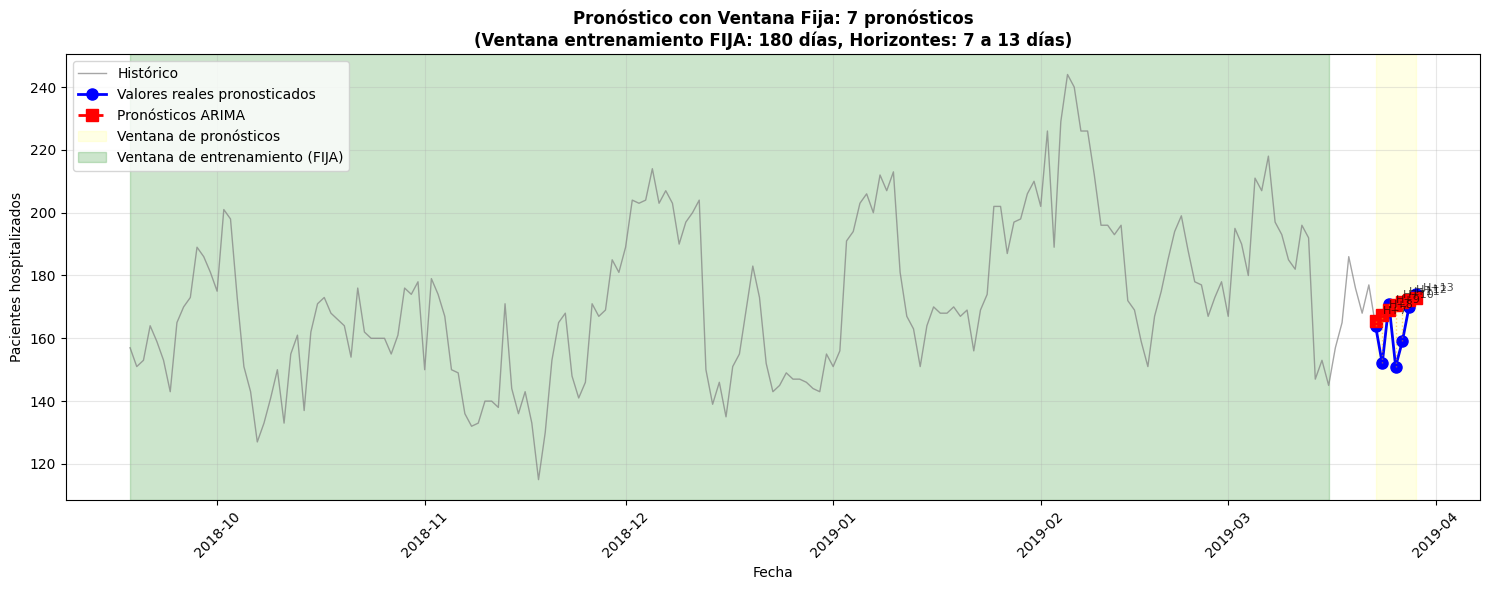


ERRORES POR PRONÓSTICO
 pronostico_num  horizonte_dias forecast_date     error  error_relativo
              1               7    2019-03-23  1.425797        0.869388
              2               8    2019-03-24 15.381042       10.119107
              3               9    2019-03-25  1.986282        1.161569
              4              10    2019-03-26 19.488297       12.906157
              5              11    2019-03-27 12.569794        7.905531
              6              12    2019-03-28  2.112579        1.242694
              7              13    2019-03-29  1.088531        0.625593


In [29]:
# Visualizar valores reales vs pronósticos con ventana fija
window = 60
# Obtener datos históricos para visualización (desde el inicio de la ventana de entrenamiento)
history_start_idx = train_start
history_df = forecast_df.iloc[history_start_idx:].reset_index(drop=True)

plt.figure(figsize=(15, 6))

# Plot histórico
plt.plot(history_df["ds"], history_df["y"], label="Histórico", color="gray", alpha=0.7, linewidth=1)

# Plot valores reales pronosticados
plt.plot(comparison_display["ds"], comparison_display["real"], 
         marker="o", markersize=8, label="Valores reales pronosticados", 
         color="blue", linewidth=2)

# Plot pronósticos
plt.plot(comparison_display["ds"], comparison_display["pronostico"], 
         marker="s", markersize=8, linestyle="--", label="Pronósticos ARIMA", 
         color="red", linewidth=2)

# Conectar cada pronóstico con su valor real
for idx, row in comparison_display.iterrows():
    plt.plot([row["ds"], row["ds"]], [row["real"], row["pronostico"]], 
             color="orange", alpha=0.5, linewidth=1, linestyle=":")

# Resaltar ventana de pronósticos
plt.axvspan(comparison_display["ds"].min(), comparison_display["ds"].max(), 
            color="yellow", alpha=0.1, label="Ventana de pronósticos")

# Marcar la ventana de entrenamiento FIJA
train_start_date = results_df.iloc[0]["train_start_date"]
train_end_date = results_df.iloc[0]["train_end_date"]
plt.axvspan(train_start_date, train_end_date, 
            color="green", alpha=0.2, label="Ventana de entrenamiento (FIJA)")

# Agregar anotaciones para los horizontes
for idx, row in results_df.iterrows():
    plt.annotate(f'H+{row["horizonte_dias"]}', 
                xy=(row["forecast_date"], row["pronostico"]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7)

plt.title(f"Pronóstico con Ventana Fija: {num_forecasts} pronósticos\n"
          f"(Ventana entrenamiento FIJA: {train_window} días, Horizontes: {forecast_ahead_start} a {forecast_ahead_start + num_forecasts - 1} días)", 
          fontsize=12, fontweight="bold")
plt.xlabel("Fecha")
plt.ylabel("Pacientes hospitalizados")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar tabla de errores por pronóstico
print("\n" + "=" * 80)
print("ERRORES POR PRONÓSTICO")
print("=" * 80)
print(results_df[["pronostico_num", "horizonte_dias", "forecast_date", "error", "error_relativo"]].to_string(index=False))
